In [7]:
import torch
import torch.nn as nn
import torchvision.datasets as dataset
import torchvision.transforms as transforms
from torch import optim
import matplotlib.pyplot as plt
import numpy as np
import torchvision.utils as vutils

In [8]:
#Constants

dataroot = 'C:/Work/DCGAN/images'

workers = 2

batch_size = 64

image_size = 64

num_channels = 3

generator_input_size = 128

generator_feat_map = 64

discriminator_feat_map = 64

ngpu=1

lr=0.0002


In [9]:
data = dataset.ImageFolder(root=dataroot, transform=transforms.Compose([
                                                    transforms.Resize(image_size),
                                                    transforms.CenterCrop(image_size),
                                                    transforms.ToTensor(),
                                                    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5)),]))

In [10]:
dataloader = torch.utils.data.DataLoader(data,batch_size,shuffle=True,num_workers=workers, pin_memory=True)

In [11]:
device  = "cuda" if torch.cuda.is_available() else "cpu"

In [12]:
device

'cuda'

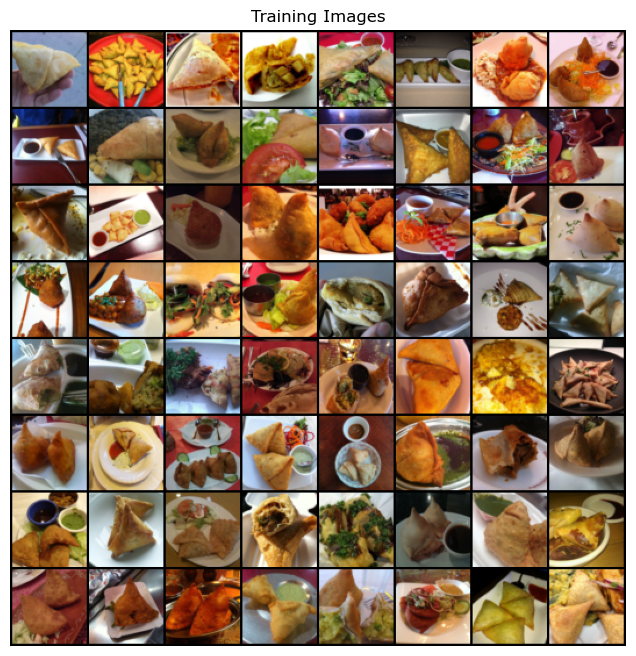

In [13]:
real_batch = next(iter(dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], normalize=True).cpu(),(1,2,0)))

In [14]:
class Generator(nn.Module):
  def __init__(self, ngpu):
    super(Generator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(

        nn.ConvTranspose2d(128, 512, 4,1,0,bias=False),
        nn.BatchNorm2d(512),
        nn.ReLU(True),
        nn.ConvTranspose2d(512,256,4,2,1,bias=False),
        nn.BatchNorm2d(256),
        nn.ReLU(True),
        nn.ConvTranspose2d(256, 128,4,2,1,bias=False),
        nn.BatchNorm2d(128),
        nn.ReLU(True),
        nn.ConvTranspose2d(128, 64,4,2,1,bias=False),
        nn.BatchNorm2d(64),
        nn.ReLU(True),
        nn.ConvTranspose2d(64, 3, 4,2,1,bias=False),
        nn.Tanh()
    )

  def forward(self, x):
      return self.main(x)

In [15]:
GEN = Generator(ngpu).to(device)

In [16]:
class Discriminator(nn.Module):
  def __init__(self, ngpu):
    super(Discriminator, self).__init__()
    self.ngpu = ngpu
    self.main = nn.Sequential(

      nn.Conv2d(3, 64, 4,2,1,bias=False),
      nn.LeakyReLU(0.2, inplace=True),
      nn.Conv2d(64, 128,4,2,1, bias=False),
      nn.BatchNorm2d(128),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Conv2d(128, 256,4,2,1, bias=False),
      nn.BatchNorm2d(256),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Conv2d(256, 512,4,2,1, bias=False),
      nn.BatchNorm2d(512),
      nn.LeakyReLU(0.2,inplace=True),
      nn.Conv2d(512,1,4,1,0,bias=False),
      nn.Sigmoid()

    )

  def forward(self, x):
      return self.main(x)

In [17]:
DSC = Discriminator(ngpu).to(device)


In [18]:
Loss = nn.BCELoss()

In [19]:
def train_discriminator(real_images, D_optim):

  D_optim.zero_grad()
  real_images = real_images.to(device)
  real_preds = DSC(real_images)
  real_targets = torch.ones(real_images.size(0),1,device=device)
  real_loss = Loss(real_preds.squeeze(dim=[1,2]), real_targets)
  real_score = torch.mean(real_preds).item()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = GEN(latent)

  fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
  fake_preds = DSC(fake_images)
  fake_loss = Loss(fake_preds.squeeze(dim=[1,2]), fake_targets)
  fake_score = torch.mean(fake_preds).item()

  loss = real_loss + fake_loss
  loss.backward()
  D_optim.step()

  return loss.item(), real_score, fake_score

In [20]:
def train_generator(G_optim):
  G_optim.zero_grad()

  latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
  fake_images = GEN(latent)

  preds = DSC(fake_images)
  targets = torch.ones(batch_size, 1, device=device)
  loss = Loss(preds.squeeze(dim=[1,2]), targets)

  loss.backward()
  G_optim.step()

  return loss.item()

In [21]:
from tqdm.notebook import tqdm

In [22]:
def fit(epochs, lr, start_idx = 1):


  losses_g = []
  losses_d = []
  real_scores = []
  fake_scores = []

  D_optim = torch.optim.Adam(DSC.parameters(), lr=lr, betas=(0.5, 0.999))
  G_optim = torch.optim.Adam(GEN.parameters(), lr=lr, betas = (0.5,0.999))

  for epoch in range(epochs):
    for real_images, _ in tqdm(dataloader):

      loss_d, real_score, fake_score = train_discriminator(real_images, D_optim)
      loss_g = train_generator(G_optim)

    losses_g.append(loss_g)
    losses_d.append(loss_d)
    real_scores.append(real_score)
    fake_scores.append(fake_score)

    print(f"Epoch: {epoch} || Generator Loss: {loss_g} || Discriminator Loss: {loss_d} ")

  return losses_g, losses_d, real_scores, fake_scores


In [23]:
lr = 0.0002
batch_size = 16
epochs = 5
latent_size = 128

In [25]:
history = fit(epochs, lr)

ImportError: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html

img_list = []
G_losses = []
D_losses = []
iters = 0

print("Starting Training Loop...")
for epoch in range(n_epochs):
    for i, data in enumerate(dataloader, 0):
        DSC.zero_grad()
        real_cpu = data[0].to(device)
        b_size = real_cpu.size(0)
        label = torch.full((b_size,), real_label, dtype=torch.float, device=device)
        output = DSC(real_cpu).view(-1)
        errD_real = criterion(output, label)
        errD_real.backward()
        D_x = output.mean().item()

        noise = torch.randn(b_size, generator_input_size, 1, 1, device=device)
        fake = GEN(noise)
        label.fill_(fake_label)
        output = DSC(fake.detach()).view(-1)
        errD_fake = criterion(output, label)
        errD_fake.backward()
        D_G_z1 = output.mean().item()
        errD = errD_real + errD_fake
        D_optimizer.step()

        GEN.zero_grad()
        label.fill_(real_label)
        output = DSC(fake).view(-1)
        errG = criterion(output, label)
        errG.backward()
        D_G_z2 = output.mean().item()
        G_optimizer.step()

        G_losses.append(errG.item())
        D_losses.append(errD.item())

        if i % 50 == 0:
            print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f\tD(x): %.4f\tD(G(z)): %.4f / %.4f'
                  % (epoch, n_epochs, i, len(dataloader),
                     errD.item(), errG.item(), D_x, D_G_z1, D_G_z2))

        if (iters % 500 == 0) or ((epoch == n_epochs-1) and (i == len(dataloader)-1)):
            with torch.no_grad():
                fake = GEN(fixed_noise).detach().cpu()
            img_list.append(vutils.make_grid(fake, padding=2, normalize=True))
        if errG<2:
          break
        iters += 1


In [ ]:
GEN.eval()
num_images = 32
noise = torch.randn(num_images, generator_input_size, 1, 1, device=device)
with torch.no_grad():
    generated_images = GEN(noise).detach().cpu()

generated_grid = vutils.make_grid(generated_images, nrow=8, padding=2, normalize=True)

plt.figure(figsize=(10,10))
plt.imshow(torch.transpose(generated_grid, 0, 2))
plt.axis('off')
plt.show()